In [2]:
import os
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as pt

def download_herten():
    # download the data, warning: its about 250MB
    print('Downloading Herten data')
    data_filename = 'data.zip'
    data_url = 'http://store.pangaea.de/Publications/Bayer_et_al_2015/Herten-analog.zip'
    urllib.request.urlretrieve(data_url, 'data.zip')

    # extract the data
    with zipfile.ZipFile(data_filename, 'r') as zf:
        zf.extract(os.path.join('Herten-analog', 'sim-big_1000x1000x140',
                                'sim.vtk'))

def download_scripts():
    # download a script for file conversion
    print('Downloading scripts')
    tools_filename = 'scripts.zip'
    tool_url = 'http://store.pangaea.de/Publications/Bayer_et_al_2015/tools.zip'
    urllib.request.urlretrieve(tool_url, tools_filename)

    # only extract the script we need
    with zipfile.ZipFile(tools_filename, 'r') as zf:
        zf.extract(os.path.join('tools', 'vtk2gslib.py'))


In [3]:
# download_herten()
# download_scripts()

In [4]:
# import the downloaded conversion script
from tools.vtk2gslib import vtk2numpy

# load the Herten aquifer with the downloaded vtk2numpy routine
print('Loading data')
herten, grid = vtk2numpy(os.path.join('Herten-analog', 'sim-big_1000x1000x140', 'sim.vtk'))

Loading data


In [5]:
# conductivity values per fazies from the supplementary data
cond = np.array([2.50E-04, 2.30E-04, 6.10E-05, 2.60E-02, 1.30E-01,
                 9.50E-02, 4.30E-05, 6.00E-07, 2.30E-03, 1.40E-04,])

# asign the conductivities to the facies
herten_cond = cond[herten]

In [6]:
# integrate over the vertical axis, calculate transmissivity
herten_log_trans = np.log(np.sum(herten_cond, axis=2) * grid['dz'])

In [7]:
def create_unstructured_grid(x_s, y_s):
    x_u, y_u = np.meshgrid(x_s, y_s)
    len_unstruct = len(x_s) * len(y_s)
    x_u = np.reshape(x_u, len_unstruct)
    y_u = np.reshape(y_u, len_unstruct)
    return x_u, y_u

# create a structured grid on which the data is defined
x_s = np.arange(grid['ox'], grid['nx']*grid['dx'], grid['dx'])
y_s = np.arange(grid['oy'], grid['ny']*grid['dy'], grid['dy'])

# create an unstructured grid for the variogram estimation
x_u, y_u = create_unstructured_grid(x_s, y_s)

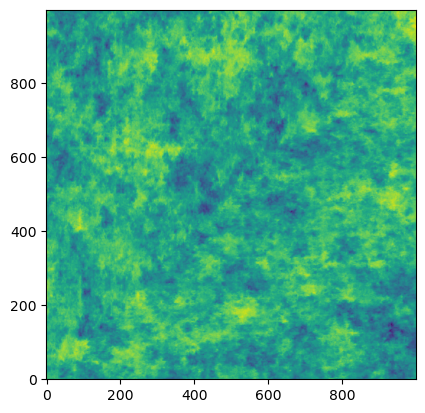

In [8]:
pt.imshow(herten_log_trans.T, origin='lower', aspect='equal')
pt.show()

In [9]:
from gstools import vario_estimate_unstructured

bins = np.linspace(0, 10, 50)
print('Estimating unstructured variogram')
bin_center, gamma = vario_estimate_unstructured(
    (x_u, y_u),
    herten_log_trans.flatten(),
    bins,
    sampling_size=2000,
    sampling_seed=19920516,
    )

Estimating unstructured variogram


In [10]:
from gstools import Exponential

# fit an exponential model
fit_model = Exponential(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

({'var': 0.020193136143208355, 'len_scale': 1.448026857683351, 'nugget': 0.0},
 array([[1.03148382e-08, 2.19579295e-06],
        [2.19579295e-06, 1.14746403e-03]]))

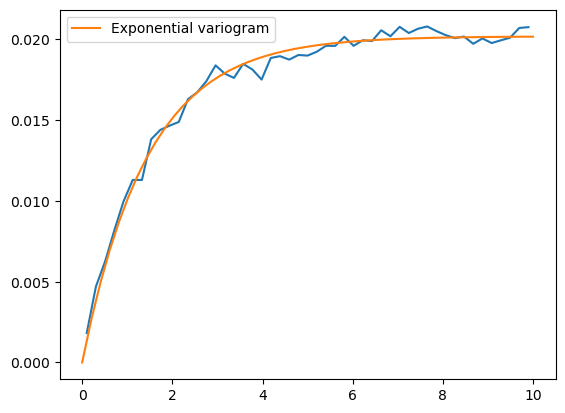

In [11]:
from gstools.covmodel.plot import plot_variogram
f, ax = pt.subplots()
ax.plot(bin_center, gamma)
plot_variogram(fit_model, x_max=bins[-1], ax = ax)
pt.show()

In [12]:
print(fit_model)


Exponential(dim=2, var=0.0202, len_scale=1.45, nugget=0.0)


In [13]:
Exponential(dim=2, var=0.020193095802479327, len_scale=1.4480057557321007, nugget=0.0, anis=[1.], angles=[0.])

Exponential(dim=2, var=0.0202, len_scale=1.45, nugget=0.0)

In [14]:
from pathlib import Path
import xarray as xr
import rioxarray
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

In [36]:
def create_unstructured_grid(x_s, y_s):
    x_u, y_u = np.meshgrid(x_s, y_s)
    len_unstruct = len(x_s) * len(y_s)
    x_u = np.reshape(x_u, len_unstruct)
    y_u = np.reshape(y_u, len_unstruct)
    return x_u, y_u

from gstools import SRF

def create_random_field(da):
    random_ds = da.copy(deep = True)
    arr = da.data
    x_u, y_u = create_unstructured_grid(da.x.data, da.y.data)
    bins = np.linspace(20, 2000, 20)
    bin_center, gamma = vario_estimate_unstructured(
            (x_u, y_u), arr.flatten(), bins, sampling_size=8000)
    fit_model = Exponential(dim=2, nugget= 0)
    fit_model.fit_variogram(bin_center, gamma, nugget=True)
    srf = SRF(fit_model, seed=19770928)
    # this transpose appears in all the documentation and is neccessary to make the data fit the original data
    random_ds.data = srf((da.x.data, da.y.data), mesh_type='structured').T

    return random_ds
        

In [114]:
ds = dss['Banner_2020-02-18'].sel(band = 'VV')
ds = ds.transpose('time', 'y', 'x')
ds = ds.rio.write_crs('EPSG:4326')
ds = ds.rio.reproject(ds.rio.estimate_utm_crs())

def create_unstructured_grid(x_s, y_s):
    x_u, y_u = np.meshgrid(x_s, y_s)
    len_unstruct = len(x_s) * len(y_s)
    x_u = np.reshape(x_u, len_unstruct)
    y_u = np.reshape(y_u, len_unstruct)
    return x_u, y_u

arr = ds['deltaVV'].isel(time = 30).data

# # create a structured grid on which the data is defined
# x_s = np.arange(grid['ox'], grid['nx']*grid['dx'], grid['dx'])
# y_s = np.arange(grid['oy'], grid['ny']*grid['dy'], grid['dy'])

# create an unstructured grid for the variogram estimation
x_u, y_u = create_unstructured_grid(ds.x.data, ds.y.data)

In [149]:
bins = np.linspace(20, 2000, 20)
print('Estimating unstructured variogram')

bin_center, gamma = vario_estimate_unstructured(
    (x_u, y_u),
    arr.flatten(),
    bins,
    sampling_size=2000,
    # sampling_seed=19920516,
    )

Estimating unstructured variogram


In [150]:
# fit an exponential model
fit_model = Exponential(dim=2, nugget= 0)
fit_model.fit_variogram(bin_center, gamma, nugget=True)

({'var': 0.3193642656270858,
  'len_scale': 197.11423945662764,
  'nugget': 0.2881281579411205},
 array([[ 1.46417673e-03, -9.70669011e-01, -1.49118605e-03],
        [-9.70669011e-01,  1.14088993e+03,  1.06912995e+00],
        [-1.49118605e-03,  1.06912995e+00,  1.55146690e-03]]))

<Axes: >

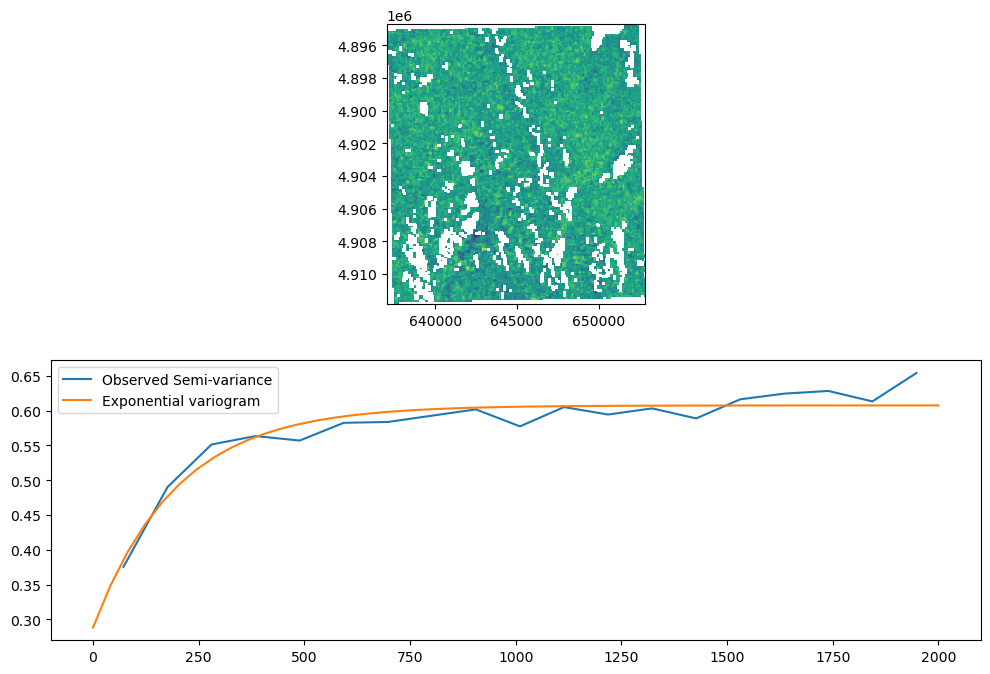

In [151]:
from gstools.covmodel.plot import plot_variogram
f, axes = pt.subplots(2, 1, figsize = (12, 8))
axes[0].imshow(arr, extent = [x_u[0], x_u[-1], y_u[0], y_u[-1]])
axes[1].plot(bin_center, gamma, label = 'Observed Semi-variance')
plot_variogram(fit_model, x_max=bins[-1], ax = axes[1])

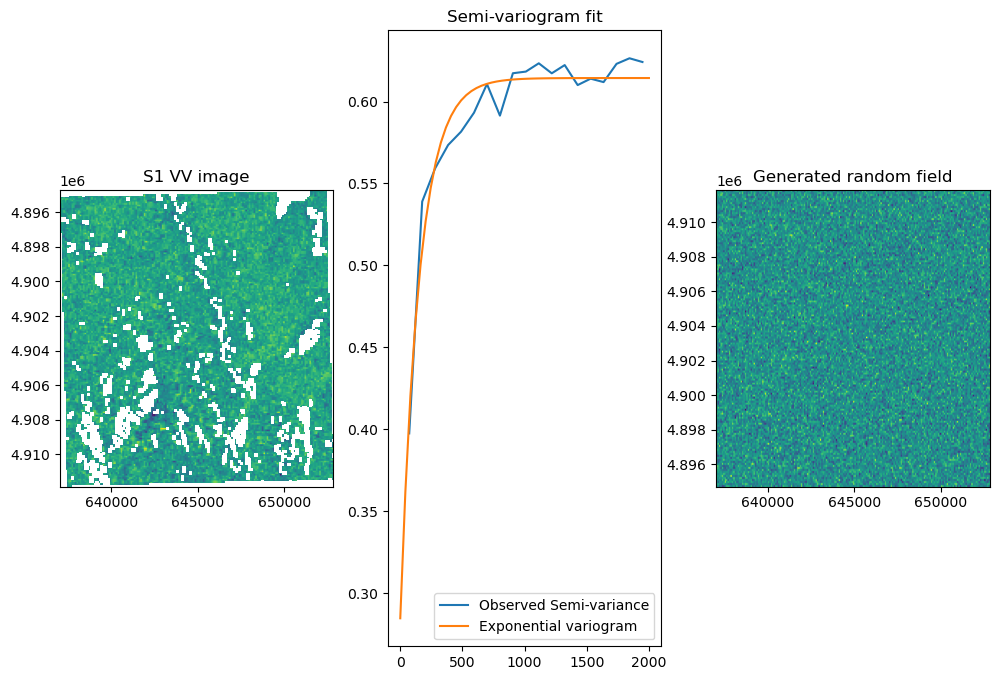

In [148]:
from gstools.covmodel.plot import plot_variogram
f, axes = pt.subplots(1, 3, figsize = (12, 8))
axes[0].imshow(arr, extent = [x_u[0], x_u[-1], y_u[0], y_u[-1]])
axes[1].plot(bin_center, gamma, label = 'Observed Semi-variance')
plot_variogram(fit_model, x_max=bins[-1], ax = axes[1])

from gstools import SRF, Gaussian

srf = SRF(fit_model, seed=19770928)
new_herten = srf((ds.x.data, ds.y.data), mesh_type='structured')

axes[2].imshow(new_herten.T, origin='lower', extent = [x_u[0], x_u[-1], y_u[-1], y_u[0]])

axes[0].set_title('S1 VV image')
axes[1].set_title('Semi-variogram fit')
axes[2].set_title('Generated random field')

pt.show()

In [140]:
ds = dss['Banner_2020-02-18'].load().isel(time = slice(12))

def make_random_timeseries(ds):
    ds = ds.rio.write_crs('EPSG:4326')
    random_ds = ds[['s1','fcf', 'ims']].copy(deep = True)

    for orbit_name, sub in ds.groupby('relative_orbit'):

        for band in ['VV','VH']:
            sub[band] = sub['s1'].sel(band = band)
        sub = sub.drop('s1')
        sub = sub.drop('band')
        sub = sub.transpose('time', 'y', 'x')
        sub = sub.rio.reproject(sub.rio.estimate_utm_crs())
        
        
        random_sub_ds = sub.copy(deep = True)
        
        # make a random visualization of VV @ t = 0 with matching variance and correlation length to real data
        random_sub_ds['VV'].loc[dict(time = sub.isel(time = 0).time)] = create_random_field(sub['VV'].isel(time = 0))

        # make VH @ t = 0 match VV with a shifted mean (arbitrary since we just use change in backscatter) to simulate the geometric drive correlation between the two 
        random_sub_ds['VH'].loc[dict(time = sub.isel(time = 0).time)] =  random_sub_ds['VV'].loc[dict(time = sub.isel(time = 0).time)] - 1
        
        sub['deltaVH'] = sub['VH'].diff(dim = 'time')

        for i, (ts, time_ds) in enumerate(sub.groupby('time')):
            if i == 0:
                continue
            # go through each time series with dVV and then dVH
            # add random field with matching spatial statistics to dVV and dVH to original image to make new timeseries
            for band in ['VV', 'VH']:
                random_sub_ds[band].loc[dict(time = ts)] = random_sub_ds[band].isel(time = 0) + create_random_field(time_ds[band] - random_sub_ds[band].isel(time = 0))
        
        
        for band in ['VV', 'VH']:
            random_ds['s1'].loc[dict(time = ds.relative_orbit == orbit_name, band = band)] = random_sub_ds[band].rio.reproject_match(random_ds['s1'].loc[dict(time = ds.relative_orbit == orbit_name, band = band)])

    return random_ds

# random_ds = make_random_timeseries(ds)

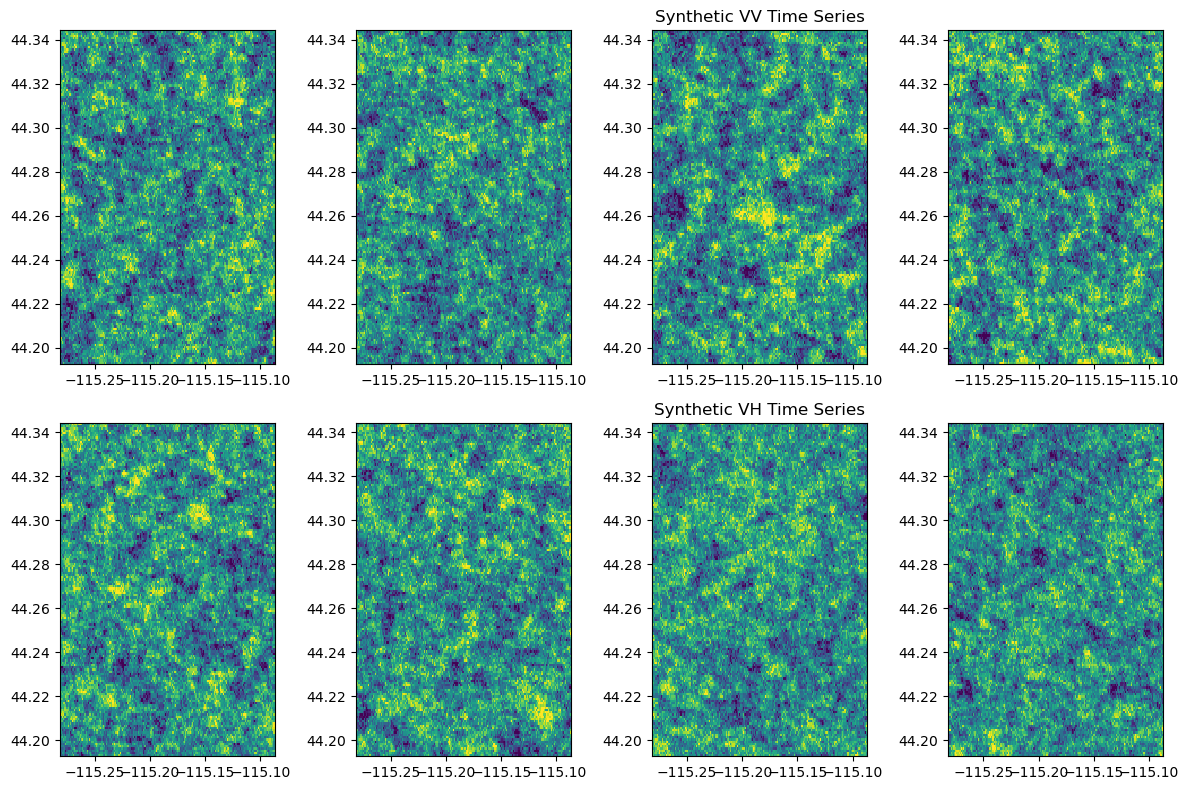

In [141]:
import matplotlib.pyplot as plt
I_s = 5
fig, axes = plt.subplots(2, I_s - 1, figsize = (12, 8))
for i in range(1, I_s):
    (random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 0) - random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = 0, band = 0)).plot(ax = axes[0, i - 1], vmin = -4, vmax = 4, add_colorbar = False)
    (random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 1) - random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = 0, band = 1)).plot(ax = axes[1, i - 1], vmin = -4, vmax = 4, add_colorbar = False)
    # random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 1).plot(ax = axes[1, i], vmin = -5, vmax = 3, add_colorbar = False)

for ax in axes.ravel():
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0,2].set_title('Synthetic VV Time Series')
axes[1,2].set_title('Synthetic VH Time Series')

plt.tight_layout()

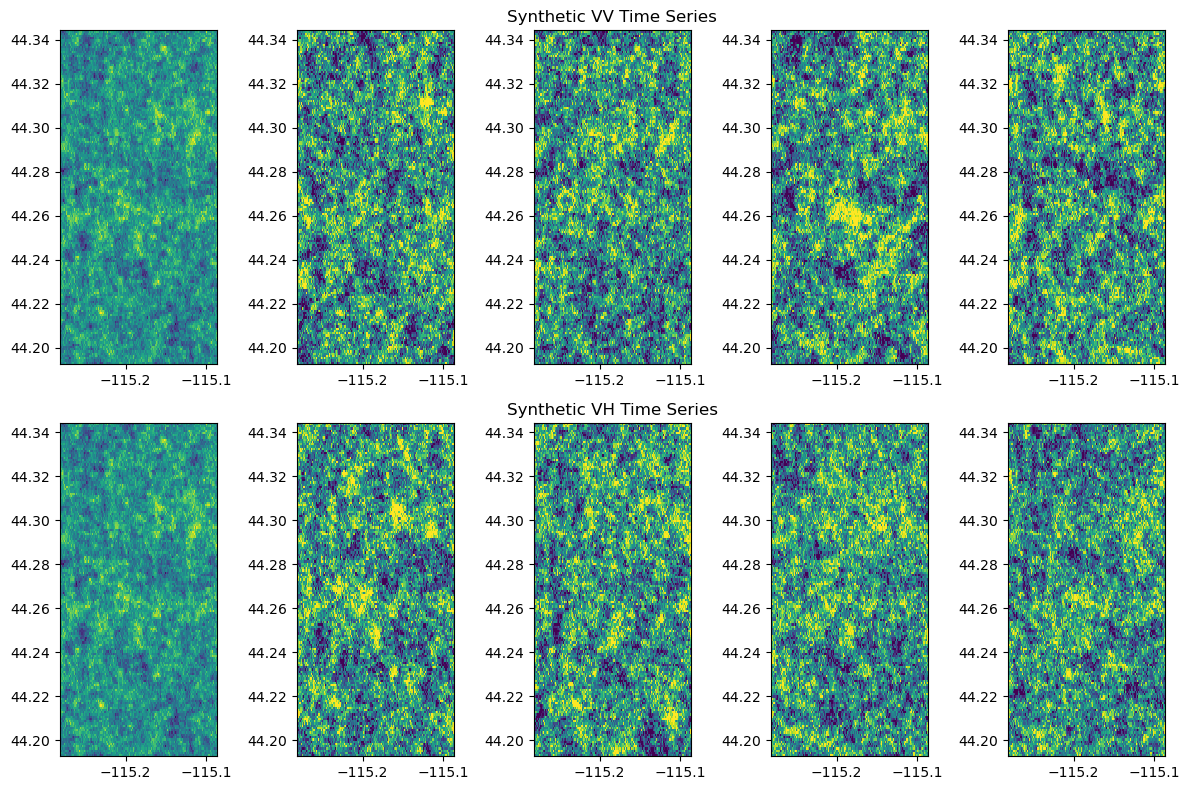

In [143]:
import matplotlib.pyplot as plt
I_s = 5
fig, axes = plt.subplots(2, I_s, figsize = (12, 8))
for i in range(I_s):
    random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 0).plot(ax = axes[0, i], vmin = -4, vmax = 4, add_colorbar = False)
    random_ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 1).plot(ax = axes[1, i], vmin = -5, vmax = 3, add_colorbar = False)

for ax in axes.ravel():
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0,2].set_title('Synthetic VV Time Series')
axes[1,2].set_title('Synthetic VH Time Series')

plt.tight_layout()

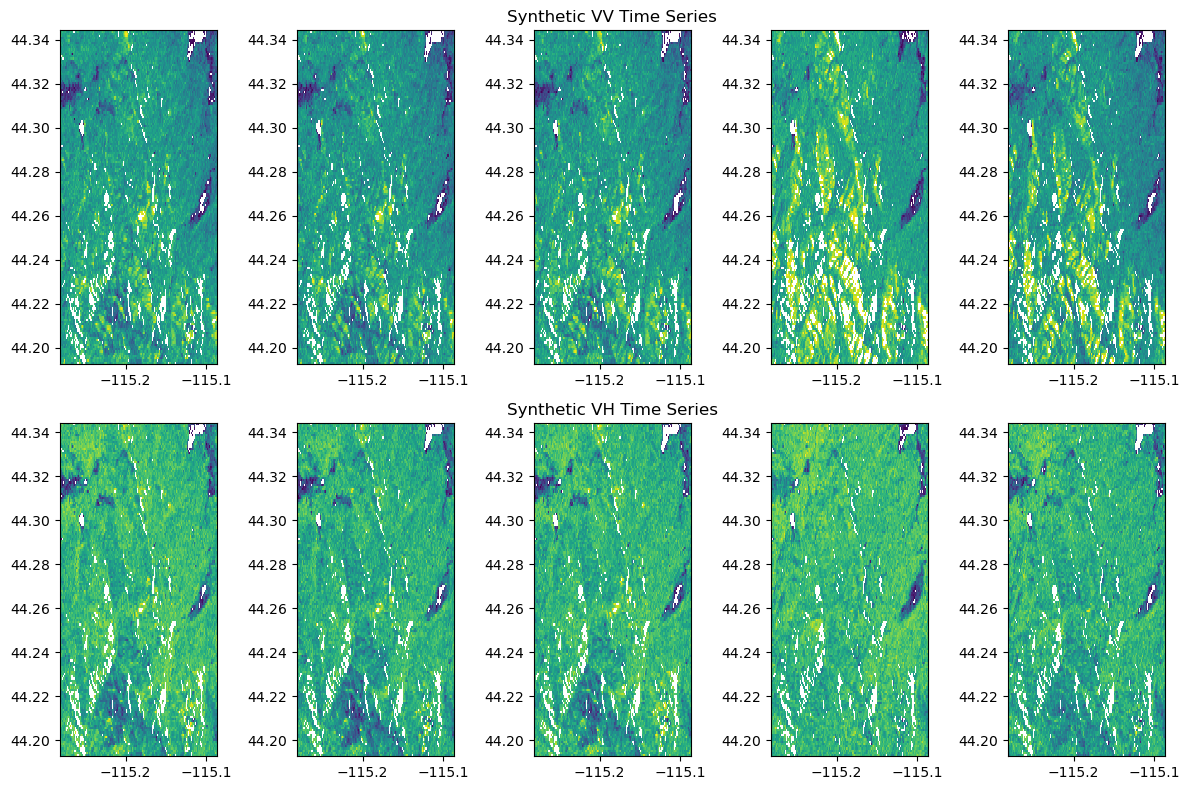

In [124]:
import matplotlib.pyplot as plt
I_s = 5
fig, axes = plt.subplots(2, I_s, figsize = (12, 8))
for i in range(I_s):
    ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 0).plot(ax = axes[0, i], add_colorbar = False)
    ds['s1'].sel(time = random_ds.relative_orbit == orbit_name).isel(time = i, band = 1).plot(ax = axes[1, i], add_colorbar = False)

for ax in axes.ravel():
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0,2].set_title('Synthetic VV Time Series')
axes[1,2].set_title('Synthetic VH Time Series')

plt.tight_layout()